In [41]:
from pathlib import Path
import pandas as pd
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [14]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
cachedir = 'cache'
memory = Memory(cachedir, verbose=0)

In [15]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'staging_data' / 'hosts_reviews_en_cleaned.parquet')

In [16]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[1])

['nice', 'flat', 'great', 'area', 'host', 'sorted', 'things', 'make', 'stay', 'smooth', 'easy', 'leaving', 'key', 'neighbours', 'etc', 'thanks']


In [17]:
nlp = spacy.load("en_core_web_sm")
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
@memory.cache
def process_words_cached(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words_cached(data_words)

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.017*"room" + 0.016*"bed" + 0.013*"kitchen" + 0.013*"good" + 0.011*"apartment" + 0.011*"small" + 0.010*"bathroom" + 0.009*"also" + 0.009*"work" + 0.008*"get"'),
 (1,
  '0.103*"host" + 0.050*"stay" + 0.046*"great" + 0.038*"place" + 0.033*"apartment" + 0.031*"location" + 0.027*"nice" + 0.026*"recommend" + 0.023*"clean" + 0.021*"really"'),
 (2,
  '0.035*"apartment" + 0.030*"walk" + 0.028*"close" + 0.021*"station" + 0.019*"city" + 0.018*"restaurant" + 0.018*"great" + 0.016*"stay" + 0.016*"minute" + 0.015*"nice"')]

In [34]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_topic', 'Percent_contribution', 'Topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'Text'
    sent_topics_df = sent_topics_df.merge(contents, left_index=True, right_index=True)
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.columns = ['Dominant_topic', 'Topic_percent_contribution', 'Keywords', 'Text']
df_dominant_topic.head()

,Dominant_topic,Topic_percent_contribution,Keywords,Text
0,2,0.626,"apartment, walk, close, station, city, restaur...","[great, little, apartment, perfect, spot, town..."
1,1,0.577,"host, stay, great, place, apartment, location,...","[nice, flat, great, area, host, sort, thing, m..."
2,0,0.587,"room, bed, kitchen, good, apartment, small, ba...","[great, location, host, responsive, email, cou..."
3,2,0.591,"apartment, walk, close, station, city, restaur...","[host, place, super, great, close, quite, cent..."
4,1,0.523,"host, stay, great, place, apartment, location,...","[nice, apartment, great, location, great, pric..."


In [35]:
df_dominant_topic.to_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.114408  0.187582       1        1  42.226604
2     -0.164892 -0.166263       2        1  30.693025
0      0.279300 -0.021319       3        1  27.080371, topic_info=        Term          Freq         Total Category  logprob  loglift
28      host  60574.000000  60574.000000  Default  30.0000  30.0000
24      walk  12572.000000  12572.000000  Default  29.0000  29.0000
70     close  11641.000000  11641.000000  Default  28.0000  28.0000
8      great  33836.000000  33836.000000  Default  27.0000  27.0000
156  station   8649.000000   8649.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
38     clean   2574.193121  19358.552820   Topic3  -4.9719  -0.7112
89     check   1955.298072   5315.197866   Topic3  -5.2468   0.3063
35      stay   2539.086164  38400.389605   Topic3  -4.9856  -1.4099
186     find   1790.981131   3267.129167   Topic3  -5.3346   0.7052
50      need   1986.766875  12047.629675   Topic3  -5.2309  -0.4960

[200 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
642       1  0.984608  accommodate
642       2  0.001427  accommodate
642       3  0.014270  accommodate
410       1  0.996496       advice
246       1  0.241857         also
...     ...       ...          ...
158       3  0.131323         well
606       2  0.000955         wifi
606       3  0.999599         wifi
886       3  0.999405       window
620       3  0.999760         work

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
topics = lda_model.show_topics(formatted=False)

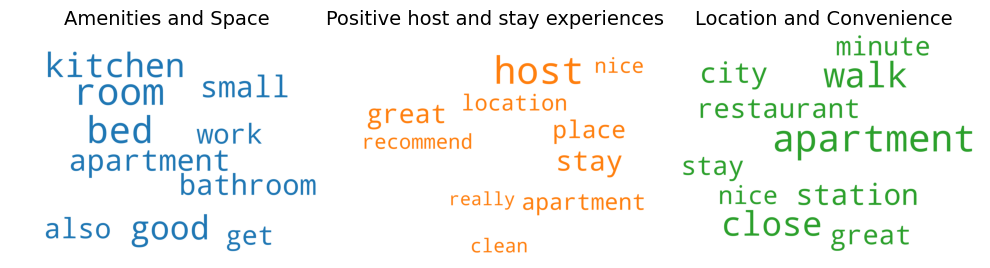

In [49]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

groups = ['Amenities and Space',
        'Positive host and stay experiences',
        'Location and Convenience']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups[i], fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()